# Question 1

In this question we will:

- Implement a segmentation algorithm that uses random walker as the primary means to segment a noisy version of the leaf dataset from the previous assignment.
- Evaluate the performance of our algorithm in terms of mean Dice coefficient.
- Examine the best and worst results that we get from the dataset.
- Reason on why the algorithm works well on the 'best' cases and what causes it to fail on the 'worst' cases.



# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `channel_axis=2`._

_Hint: you may need to adjust the `beta` and `tol` arguments to the `ramdom_walker()` function to get excellent results._

_Hint: Output of the `random_walker()` function may be further post-processed using region processing methods._

In [3]:
import numpy as np
from scipy.ndimage import uniform_filter, binary_erosion  # local stats + conservative seeds
from scipy.ndimage import binary_fill_holes
from skimage import morphology, measure
from skimage.segmentation import random_walker

def segleaf(I, win= 9, p_fg=70, p_bg=50, frac_fg=0.65, frac_bg=0.35, 
            beta=150, tol=1e-2, min_size=100, hole_area=100):
    R, G, B = I[:, :, 0], I[:, :, 1], I[:, :, 2]

    # Excessive Green Index from normalized colour channels
    S = R + G + B + 1e-8
    r, g, b = R / S, G / S, B / S
    exg = 2.0 * g - r - b

    # local statistics for robustness to pixel noise
    EXG_mean = uniform_filter(exg.astype(np.float32), size=win)
    green_dom = (G >= R) & (G >= B)
    green_frac = uniform_filter(green_dom.astype(np.float32), size=win)

    # percentile thresholds computed on local mean
    hi = np.percentile(EXG_mean, p_fg)
    lo = np.percentile(EXG_mean, p_bg)

    # initial seeds from local consensus
    fg_seed = (EXG_mean >= hi) & (green_frac >= frac_fg) & green_dom
    bg_seed = (EXG_mean <= lo) & (green_frac <= frac_bg)

    # make seeds conservative (erode to avoid boundaries)
    fg_seed = binary_erosion(fg_seed)
    bg_seed = binary_erosion(bg_seed)

    # markers: 0=unknown, 1=leaf, 2=background
    markers = np.zeros(exg.shape, dtype=np.int32)
    markers[fg_seed] = 1
    markers[bg_seed] = 2

    # Random walk to assign labels
    labels = random_walker(I, markers, beta=beta, tol=tol, channel_axis=2)

    # final binary mask from RW labels
    mask = (labels == 1)

    # Cleanup
    mask = morphology.remove_small_objects(mask, min_size=min_size)
    mask = morphology.remove_small_holes(mask, area_threshold=hole_area) 
    lbl = measure.label(mask, connectivity=2)
    if lbl.max() > 0:
        cnt = np.bincount(lbl.ravel()); cnt[0] = 0
        mask = (lbl == np.argmax(cnt))
    mask = binary_fill_holes(mask)

    # Smooth edges
    fp = morphology.disk(4)
    mask = morphology.binary_closing(mask, footprint=fp)
    mask = morphology.binary_opening(mask, footprint=fp)

    return mask, markers


94
0.3686274509803922
(592, 896, 3)
uint8
(592, 896)
uint8
bool


c:\Users\predi\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


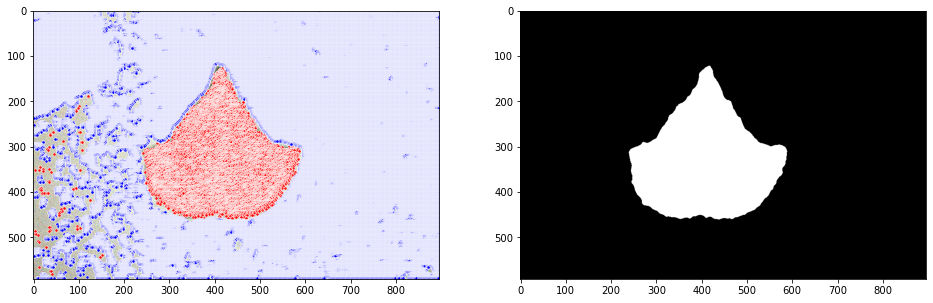

In [11]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float

test_img = imread("noisyimages/image_0161.png")

print(test_img[...,0][0,0])
print(img_as_float(test_img[...,0][0,0]))

gtruth_img = imread("groundtruth/image_0113.png")
print(test_img.shape)
print(test_img.dtype)
print(gtruth_img.shape)
print(gtruth_img.dtype)

mask, markers = segleaf(img_as_float(test_img), win=15, p_fg=85, p_bg=75, 
                        frac_fg=0.30, frac_bg=0.70, 
                        beta=50, tol=1e-2, min_size=100, hole_area=100)
print(mask.dtype)

leafX, leafY = np.nonzero(markers==1)
bgX, bgY = np.nonzero(markers==2)

fig,ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(test_img)
ax[0].scatter(leafY, leafX, c='red', s=10, marker='o', 
              linewidths=0.5, edgecolors='white', label='FG seeds', alpha=0.9)
ax[0].scatter(bgY, bgX, c='blue', s=10, marker='o', 
              linewidths=0.5, edgecolors='white', label='FG seeds', alpha=0.9)
ax[1].imshow(mask, cmap='gray')

# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `noisyimages` directory):

* load the noisy image and it's ground truth
* segment the input image using the function you wrote in Step 1.
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, print the average DSC for all images.  If you're getting a mean DSC of greater than 0.85, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [5]:
import pandas as pd
from skimage.io import imread
from skimage.util import img_as_float

def dice(seg, gt):
    seg = seg.astype(bool)
    gt  = gt.astype(bool)
    inter = np.logical_and(seg, gt).sum()
    denom = seg.sum() + gt.sum()
    return (2.0 * inter) / (denom + 1e-8)

files = pd.read_csv("images.csv", header=None)
png_list = files[0].tolist()

images = [img_as_float(imread(f"noisyimages/{png}")) for png in png_list] # Colour images of leaves
groundtruths = [img_as_float(imread(f"groundtruth/{png}")) > 0.5 for png in png_list] # Boolean mask of ground truths

segments = [segleaf(image, win=15, p_fg=85, p_bg=75, 
                        frac_fg=0.30, frac_bg=0.70, 
                        beta=50, tol=1e-2, min_size=100, hole_area=100) 
                        for image in images] # Boolean mask of leave images made by my algorithm

dscs = [dice(segment[0], groundtruth) for segment, groundtruth in zip(segments, groundtruths)] # List of dice values

recognized = [dsc > 0.6 for dsc in dscs]  # List of booleans stating whether a leaf was or wasnt recognized (ie dsc was > 0.6)

for fname, dsc in zip(png_list, dscs):
    print(f"DSC for {fname}: {dsc}")
    print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

print(f"The mean Dice coefficient was: {np.mean(dscs)}")
print(f"The std. deviation of Dice coefficient was: {np.std(dscs)}")
print(f"{np.mean(recognized)*100}% of leaves were recognized")

c:\Users\predi\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


DSC for image_0001.png: 0.9853390786239342
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0002.png: 0.9765597065327583
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0005.png: 0.9883496671764727
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0007.png: 0.9867828680077796
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0009.png: 0.989677297006796
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0010.png: 0.9907687449136396
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0011.png: 0.9871635416421639
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


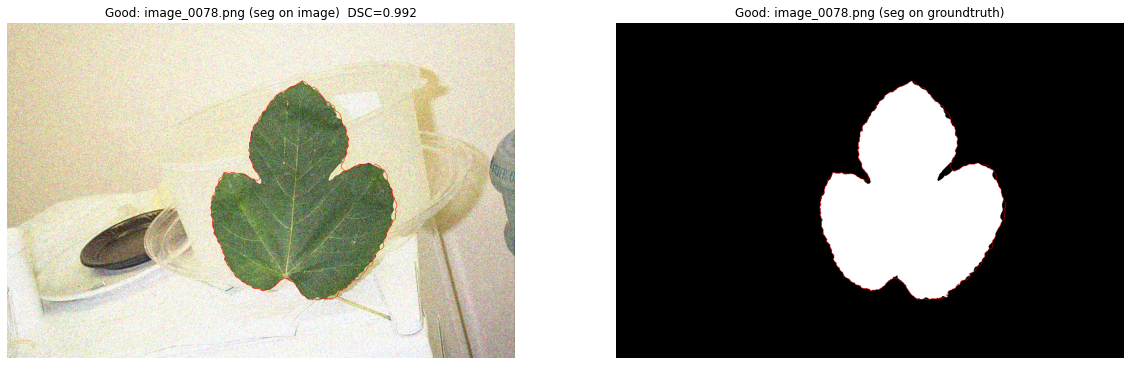

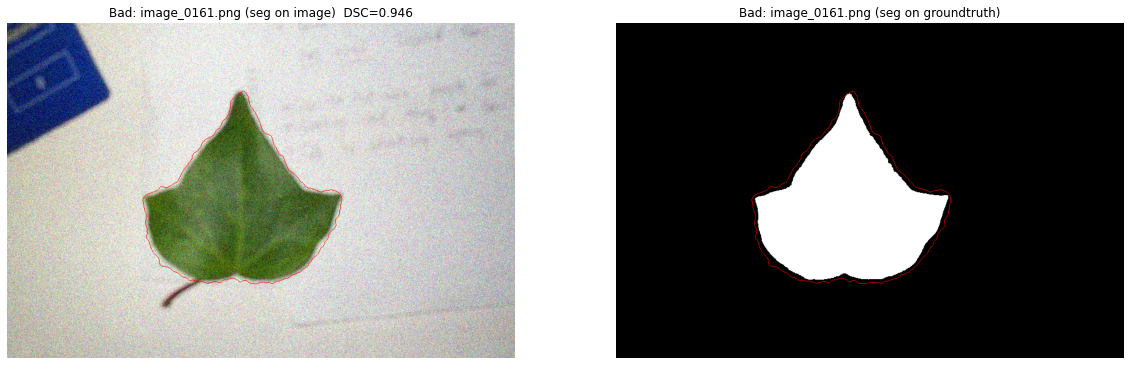

In [10]:
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

def overlay_contour(image, mask, color=(1, 0, 0)):
    b = find_boundaries(mask, mode='outer')
    out = image.copy()
    out = img_as_float(out)
    rr, cc = np.nonzero(b)
    out[rr, cc, :] = color
    return out

# Using DSC for criteria
best_idx = np.argmax(dscs)
worst_idx = np.argmin(dscs)

for label, idx in [('Good', best_idx), ('Bad', worst_idx)]:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(overlay_contour(images[idx], segments[idx][0]))
    axes[0].set_title(f'{label}: {png_list[idx]} (seg on image)  DSC={dscs[idx]:.3f}')
    axes[0].axis('off')
    gt_rgb = np.dstack([groundtruths[idx], groundtruths[idx], groundtruths[idx]]).astype(float)
    axes[1].imshow(overlay_contour((gt_rgb*255).astype(np.uint8), segments[idx][0]))
    axes[1].set_title(f'{label}: {png_list[idx]} (seg on groundtruth)')
    axes[1].axis('off')
    plt.show()


# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	My segmentation algorithm works very similarly to last assignment, only now instead of computing a per pixel determination of the excessive green index is checks regions of pixels for average greenness to make labels. I also build a binary map that tells me places that are dominated by green, and a map that tells me places that on average are dominated by green. This gives me access to tuning a number of parameters, mainly the percentiles I keep of the upper and lower excessive green, and the fraction of pixels I keep from the the average pixel is dominently green. By using a bitwise AND I can label places where all of my conditions are met at once as leaf starting points, and all of the places the background requirements are met as background. I also found I had trouble with boundaries getting crowded out so I do a binary erosion to pull both groups of labels toward strong clusters. From there it's just about assigning the right labels to the right markers, running the random_walker, and cleaning up the results. I remove small objects and fill small holes which removes any erroneous labels, take advantage of the fact there is only 1 leaf per image, then blur the edges a bit to make them smoother.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	I think the binary erosion of the labels makes it difficult for my algorithm to get into narrow regions of background. Thats why we can see that the mask jumps from one leave part to the next a little early. Overall the shape is correct but small details like that are eroded away through the various cleanup steps I do.

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	My best guess for what happened here is my labelling algorithm was actually too good. Since I have close to a 50/50 split of background and leaf points in my labels, eroding them both equally disproportionatly effected the background, since it was spread out over more space. This in turn allowed some of the backgroun points to be closer to the leaf labels than the background labels, and the result was the border expanding in all directions as we see in the results.

4. I would like to note that even though the binary erosion seems to be my limitting factor, it actually results in much better results for a number of the intermediate DICE valued leaves. Removing it entirely results in places where small groups of baground labels inside the leaf result in cutout sections of the mask. As such even though it is less ideal on the extremes, on average it is helping more than its hurting